# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
import markdown
from IPython.display import display, Markdown
from sklearn.preprocessing import StandardScaler

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")

In [4]:
#Display data dictionary
def display_md_content(file_path):
    # Read the contents of the .md file
    with open(file_path, 'r') as file:
        markdown_text = file.read()

    # Convert Markdown to HTML
    html_content = markdown.markdown(markdown_text)

    # Convert HTML to Markdown and display in the notebook
    display(Markdown(html_content))

# Usage example
display_md_content('Data_Dictionary.md')


<h1>Data Dictionary for Identify Customer Segments Data</h1>
<h2>Introduction</h2>
<p>The data for this project consist of two files:</p>
<ul>
<li>Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)</li>
<li>Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)</li>
</ul>
<p>The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.</p>
<h3>Table of Contents</h3>
<ol>
<li>Person-level features</li>
<li>Household-level features</li>
<li>Building-level features</li>
<li>RR4 micro-cell features</li>
<li>RR3 micro-cell features</li>
<li>Postcode-level features</li>
<li>RR1 neighborhood features</li>
<li>PLZ8 macro-cell features</li>
<li>Community-level features</li>
</ol>
<hr />
<h2>1. Person-level features</h2>
<h3>1.1. AGER_TYP</h3>
<p>Best-ager typology
- -1: unknown
-  0: no classification possible
-  1: passive elderly
-  2: cultural elderly
-  3: experience-driven elderly</p>
<h3>1.2. ALTERSKATEGORIE_GROB</h3>
<p>Estimated age based on given name analysis
- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: &lt; 30 years old
-  2: 30 - 45 years old
-  3: 46 - 60 years old
-  4: &gt; 60 years old
-  9: uniformly distributed</p>
<h3>1.3. ANREDE_KZ</h3>
<p>Gender
- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: male
-  2: female</p>
<h3>1.4. CJT_GESAMTTYP</h3>
<p>Customer-Journey-Typology: preferred information and buying channels for
consumer
- 0: unknown
- 1: Advertising- and Consumptionminimalist
- 2: Advertising- and Consumptiontraditionalist
- 3: advertisinginterested Store-shopper
- 4: advertisinginterested Online-shopper
- 5: Advertising- and Cross-Channel-Enthusiast
- 6: Advertising-Enthusiast with restricted Cross-Channel-Behaviour</p>
<h3>1.5. FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_ANLEGER,</h3>
<h3>FINANZ_UNAUFFAELLIGER, FINANZ_HAUSBAUER</h3>
<p>Financial typology, for each dimension:
- -1: unknown
-  1: very high
-  2: high
-  3: average
-  4: low
-  5: very low</p>
<p>Dimension translations:
- MINIMALIST: low financial interest
- SPARER: money-saver
- VORSORGER: be prepared
- ANLEGER: investor
- UNAUFFAELLIGER: inconspicuous
- HAUSBAUER: home ownership</p>
<h3>1.6. FINANZTYP</h3>
<p>Most descriptive financial type for individual
- -1: unknown
-  1: low financial interest (MINIMALIST)
-  2: money-saver (SPARER)
-  3: home ownership (HAUSBAUER)
-  4: be prepared (VORSORGER)
-  5: investor (ANLEGER)
-  6: inconspicuous (UNAUFFAELLIGER)</p>
<h3>1.7. GEBURTSJAHR</h3>
<p>Year of birth
- missing data encoded as 0</p>
<h3>1.8. GFK_URLAUBERTYP</h3>
<p>Vacation habits
-  1: Event travelers
-  2: Family-oriented vacationists
-  3: Winter sportspeople
-  4: Culture lovers
-  5: Nature fans
-  6: Hiker
-  7: Golden ager
-  8: Homeland-connected vacationists
-  9: Package tour travelers
- 10: Connoisseurs
- 11: Active families
- 12: Without vacation</p>
<h3>1.9. GREEN_AVANTGARDE</h3>
<p>Membership in environmental sustainability as part of youth
- 0: not a member of green avantgarde
- 1: member of green avantgarde</p>
<h3>1.10. HEALTH_TYP</h3>
<p>Health typology
- -1: unknown
-  0: classification not possible
-  1: critical reserved
-  2: sanitary affine<br />
-  3: jaunty hedonists</p>
<h3>1.11. LP_LEBENSPHASE_FEIN</h3>
<p>Life stage, fine scale
-  1: single low-income earners of younger age
-  2: single low-income earners of middle age
-  3: single average earners of younger age
-  4: single average earners of middle age
-  5: single low-income earners of advanced age
-  6: single low-income earners at retirement age
-  7: single average earners of advanced age
-  8: single average earners at retirement age
-  9: single independent persons
- 10: wealthy single homeowners
- 11: single homeowners of advanced age
- 12: single homeowners at retirement age
- 13: single top earners of higher age
- 14: low-income and average earner couples of younger age
- 15: low-income earner couples of higher age
- 16: average earner couples of higher age
- 17: independent couples
- 18: wealthy homeowner couples of younger age
- 19: homeowner couples of higher age
- 20: top earner couples of higher age
- 21: single parent low-income earners
- 22: single parent average earners
- 23: single parent high-income earners
- 24: low-income earner families
- 25: average earner families
- 26: independent families
- 27: homeowner families
- 28: top earner families
- 29: low-income earners of younger age from multiperson households
- 30: average earners of younger age from multiperson households
- 31: low-income earners of higher age from multiperson households
- 32: average earners of higher age from multiperson households
- 33: independent persons of younger age from multiperson households
- 34: homeowners of younger age from multiperson households
- 35: top earners of younger age from multiperson households
- 36: independent persons of higher age from multiperson households
- 37: homeowners of advanced age from multiperson households
- 38: homeowners at retirement age from multiperson households
- 39: top earners of middle age from multiperson households
- 40: top earners at retirement age from multiperson households</p>
<h3>1.12. LP_LEBENSPHASE_GROB</h3>
<p>Life stage, rough scale
-  1: single low-income and average earners of younger age
-  2: single low-income and average earners of higher age
-  3: single high-income earners
-  4: single low-income and average-earner couples
-  5: single high-income earner couples
-  6: single parents
-  7: single low-income and average earner families
-  8: high-income earner families
-  9: average earners of younger age from multiperson households
- 10: low-income and average earners of higher age from multiperson households
- 11: high-income earners of younger age from multiperson households
- 12: high-income earners of higher age from multiperson households</p>
<h3>1.13. LP_FAMILIE_FEIN</h3>
<p>Family type, fine scale
-  0: unknown
-  1: single
-  2: couple
-  3: young single parent
-  4: single parent with teenager
-  5: single parent with child of full age
-  6: young family
-  7: family with teenager
-  8: family with child of full age
-  9: shared flat
- 10: two-generational household
- 11: multi-generational household</p>
<h3>1.14. LP_FAMILIE_GROB</h3>
<p>Family type, rough scale
- 0: unknown
- 1: single (maps to 1 in fine scale)
- 2: couple (maps to 2 in fine scale)
- 3: single parent (maps to 3-5 in fine scale)
- 4: family (maps to 6-8 in fine scale)
- 5: multiperson household (maps to 9-11 in fine scale)</p>
<h3>1.15. LP_STATUS_FEIN</h3>
<p>Social status, fine scale
-  1: typical low-income earners
-  2: orientation-seeking low-income earners
-  3: aspiring low-income earners
-  4: villagers
-  5: minimalistic high-income earners
-  6: independent workers
-  7: title holder-households
-  8: new houseowners
-  9: houseowners
- 10: top earners</p>
<h3>1.16. LP_STATUS_GROB</h3>
<p>Social status, rough scale
- 1: low-income earners (maps to 1-2 in fine scale)
- 2: average earners (maps to 3-5 in fine scale)
- 3: independents (maps to 6-7 in fine scale)
- 4: houseowners (maps to 8-9 in fine scale)
- 5: top earners (maps to 10 in fine scale)</p>
<h3>1.17. NATIONALITAET_KZ</h3>
<p>Nationality based on given name analysis
- -1: unknown
-  0: unknown
-  1: German-sounding
-  2: foreign-sounding
-  3: assimilated names</p>
<h3>1.18. PRAEGENDE_JUGENDJAHRE</h3>
<p>Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)</p>
<h3>1.19. RETOURTYP_BK_S</h3>
<p>Return type
- 0: unknown
- 1: influenceable Crazy-Shopper
- 2: demanding Heavy-Returner
- 3: incentive-receptive Normal-Returner
- 4: conservative Low-Returner
- 5: determined Minimal-Returner</p>
<h3>1.20. SEMIO_SOZ, SEMIO_FAM, SEMIO_REL, SEMIO_MAT, SEMIO_VERT, SEMIO_LUST,</h3>
<h3>SEMIO_ERL, SEMIO_KULT, SEMIO_RAT, SEMIO_KRIT, SEMIO_DOM, SEMIO_KAEM,</h3>
<h3>SEMIO_PFLICHT, SEMIO_TRADV</h3>
<p>Personality typology, for each dimension:
- -1: unknown
-  1: highest affinity
-  2: very high affinity
-  3: high affinity
-  4: average affinity
-  5: low affinity
-  6: very low affinity
-  7: lowest affinity
-  9: unknown</p>
<p>Dimension translations:
- SOZ: socially-minded
- FAM: family-minded
- REL: religious
- MAT: materialistic
- VERT: dreamful
- LUST: sensual-minded
- ERL: event-oriented
- KULT: cultural-minded
- RAT: rational
- KRIT: critical-minded
- DOM: dominant-minded
- KAEM: combative attitude
- PFLICHT: dutiful
- TRADV: tradional-minded</p>
<h3>1.21. SHOPPER_TYP</h3>
<p>Shopper typology
- -1: unknown
-  0: external supplied hedonists
-  1: Shopping-stressed
-  2: family-shopper
-  3: demanding shopper</p>
<h3>1.22. SOHO_KZ</h3>
<p>Small office / home office flag
- -1: unknown
- 0: no small office/home office
- 1: small office/home office</p>
<h3>1.23. TITEL_KZ</h3>
<p>Academic title flag
- -1: unknown
-  0: unknown
-  1: Dr.
-  2: Dr. Dr.
-  3: Prof.
-  4: Prof. Dr.
-  5: other</p>
<h3>1.24. VERS_TYP</h3>
<p>Insurance typology
- -1: unknown
-  1: social-safety driven
-  2: individualistic-accepting risks</p>
<h3>1.25. ZABEOTYP</h3>
<p>Energy consumption typology
- -1: unknown
-  1: green
-  2: smart
-  3: fair supplied
-  4: price driven
-  5: seeking orientation
-  6: indifferent
-  9: unknown</p>
<hr />
<h2>2. Household-level features</h2>
<h3>2.1. ALTER_HH</h3>
<p>Birthdate of head of household
-  0: unknown / no main age detectable
-  1: 1895-01-01 to 1899-12-31
-  2: 1900-01-01 to 1904-12-31
-  3: 1905-01-01 to 1909-12-31
-  4: 1910-01-01 to 1914-12-31
-  5: 1915-01-01 to 1919-12-31
-  6: 1920-01-01 to 1924-12-31
-  7: 1925-01-01 to 1929-12-31
-  8: 1930-01-01 to 1934-12-31
-  9: 1935-01-01 to 1939-12-31
- 10: 1940-01-01 to 1944-12-31
- 11: 1945-01-01 to 1949-12-31
- 12: 1950-01-01 to 1954-12-31
- 13: 1955-01-01 to 1959-12-31
- 14: 1960-01-01 to 1964-12-31
- 15: 1965-01-01 to 1969-12-31
- 16: 1970-01-01 to 1974-12-31
- 17: 1975-01-01 to 1979-12-31
- 18: 1980-01-01 to 1984-12-31
- 19: 1985-01-01 to 1989-12-31
- 20: 1990-01-01 to 1994-12-31
- 21: 1995-01-01 to 1999-12-31</p>
<h3>2.2. ANZ_PERSONEN</h3>
<p>Number of adults in household</p>
<h3>2.3. ANZ_TITEL</h3>
<p>Number of professional academic title holders in household</p>
<h3>2.4. HH_EINKOMMEN_SCORE</h3>
<p>Estimated household net income
- -1: unknown
-  0: unknown
-  1: highest income
-  2: very high income
-  3: high income
-  4: average income
-  5: lower income
-  6: very low income</p>
<h3>2.5. KK_KUNDENTYP</h3>
<p>Consumer pattern over past 12 months
- -1: unknown
-  1: regular customer
-  2: active customer
-  3: new costumer
-  4: stray customer
-  5: inactive customer
-  6: passive customer</p>
<h3>2.6. W_KEIT_KIND_HH</h3>
<p>Likelihood of children in household
- -1: unknown
-  0: unknown
-  1: most likely
-  2: very likely
-  3: likely
-  4: average
-  5: unlikely
-  6: very unlikely</p>
<h3>2.7. WOHNDAUER_2008</h3>
<p>Length of residence
- -1: unknown
-  0: unknown
-  1: length of residence less than 1 year
-  2: length of residence 1-2 years
-  3: length of residence 2-3 years
-  4: length of residence 3-4 years
-  5: length of residence 4-5 years
-  6: length of residence 5-6 years
-  7: length of residence 6-7 years
-  8: length of residence 7-10 years
-  9: length of residence more than 10 years</p>
<hr />
<h2>3. Building-level features</h2>
<h3>3.1. ANZ_HAUSHALTE_AKTIV</h3>
<p>Number of households in the building
- missing values encoded by 0</p>
<h3>3.2. ANZ_HH_TITEL</h3>
<p>Number of professional academic title holders in building</p>
<h3>3.3. GEBAEUDETYP</h3>
<p>Type of building (residential vs. commercial)
- -1: unknown
-  0: unknown
-  1: residential building
-  2: residential building buildings without actually known household
-  3: mixed (=residential and company) building
-  4: mixed building without actually known household or company
-  5: company building w/o known company
-  6: mixed building without actually known household
-  7: company building
-  8: mixed building without actually known company</p>
<h3>3.4. KONSUMNAEHE</h3>
<p>Distance from building to point of sale (PoS)
- 1: building is located in a 125 x 125m grid cell (RA1), which is a
     consumption cell
- 2: building is located in a 250 x 250m grid cell that includes at least one
     RA1-consumption cell
- 3: building is located in a 500 x 500m grid cell that includes at least one
     RA1-consumption cell
- 4: building is located in a 1 x 1km grid cell that includes at least one
     RA1-consumption cell
- 5: building is located in a 2 x 2km grid cell that includes at least one
     RA1-consumption cell
- 6: building is located in a 10 x 10km grid cell that includes at least one
     RA1-consumption cell
- 7: building is not located in a 10 x 10km range of a consumption cell</p>
<h3>3.5. MIN_GEBAEUDEJAHR</h3>
<p>First year building was mentioned in the database
- missing values encoded by 0</p>
<h3>3.6. OST_WEST_KZ</h3>
<p>Building location via former East / West Germany (GDR / FRG)
- -1: unknown
-  O: East (GDR)
-  W: West (FRG)</p>
<h3>3.7. WOHNLAGE</h3>
<p>Neighborhood quality (or rural flag)
- -1: unknown
-  0: no score calculated
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood</p>
<hr />
<h2>4. RR4 micro-cell features</h2>
<h3>4.1. CAMEO_DEUG_2015</h3>
<p>German CAMEO: Wealth / Life Stage Typology, rough scale
- -1: unknown
-  1: upper class
-  2: upper middleclass
-  3: established middleclass
-  4: consumption-oriented middleclass
-  5: active middleclass
-  6: low-consumption middleclass
-  7: lower middleclass
-  8: working class
-  9: urban working class
-  X: unknown</p>
<h3>4.2. CAMEO_DEU_2015</h3>
<p>German CAMEO: Wealth / Life Stage Typology, detailed scale
- 1A: Work-Life-Balance
- 1B: Wealthy Best Ager
- 1C: Successful Songwriter
- 1D: Old Nobility
- 1E: City Nobility
- 2A: Cottage Chic
- 2B: Noble Jogger
- 2C: Established gourmet
- 2D: Fine Management
- 3A: Career &amp; Family
- 3B: Powershopping Families
- 3C: Rural Neighborhood
- 3D: Secure Retirement
- 4A: Family Starter
- 4B: Family Life
- 4C: String Trimmer
- 4D: Empty Nest
- 4E: Golden Ager
- 5A: Younger Employees
- 5B: Suddenly Family
- 5C: Family First
- 5D: Stock Market Junkies
- 5E: Coffee Rider
- 5F: Active Retirement
- 6A: Jobstarter
- 6B: Petty Bourgeois
- 6C: Long-established
- 6D: Sportgardener
- 6E: Urban Parents
- 6F: Frugal Aging
- 7A: Journeymen
- 7B: Mantaplatte
- 7C: Factory Worker
- 7D: Rear Window
- 7E: Interested Retirees
- 8A: Multi-culteral
- 8B: Young &amp; Mobile
- 8C: Prefab
- 8D: Town Seniors
- 9A: First Shared Apartment
- 9B: Temporary Workers
- 9C: Afternoon Talk Show
- 9D: Mini-Jobber
- 9E: Socking Away
- XX: unknown</p>
<h3>4.3. CAMEO_INTL_2015</h3>
<p>German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples &amp; Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &amp;  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples &amp; Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families &amp; Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples &amp; Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families &amp; Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples &amp; Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families &amp; Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples &amp; Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families &amp; Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown</p>
<hr />
<h2>5. RR3 micro-cell features</h2>
<h3>5.1. KBA05_ANTG1</h3>
<p>Number of 1-2 family houses in the microcell
- -1: unknown
-  0: no 1-2 family homes
-  1: lower share of 1-2 family homes
-  2: average share of 1-2 family homes
-  3: high share of 1-2 family homes
-  4: very high share of 1-2 family homes</p>
<h3>5.2. KBA05_ANTG2</h3>
<p>Number of 3-5 family houses in the microcell
- -1: unknown
-  0: no 3-5 family homes
-  1: lower share of 3-5 family homes
-  2: average share of 3-5 family homes
-  3: high share of 3-5 family homes
-  4: very high share of 3-5 family homes</p>
<h3>5.3. KBA05_ANTG3</h3>
<p>Number of 6-10 family houses in the microcell
- -1: unknown
-  0: no 6-10 family homes
-  1: lower share of 6-10 family homes
-  2: average share of 6-10 family homes
-  3: high share of 6-10 family homes</p>
<h3>5.4. KBA05_ANTG4</h3>
<p>Number of 10+ family houses in the microcell
- -1: unknown
-  0: no 10+ family homes
-  1: lower share of 10+ family homes
-  2: high share of 10+ family homes</p>
<h3>5.5. KBA05_BAUMAX</h3>
<p>Most common building type within the microcell
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes in the microcell
-  2: mainly 3-5 family homes in the microcell
-  3: mainly 6-10 family homes in the microcell
-  4: mainly 10+ family homes in the microcell
-  5: mainly business buildings in the microcell</p>
<h3>5.6. KBA05_GBZ</h3>
<p>Number of buildings in the microcell
- -1: unknown
-  0: unknown
-  1: 1-2 buildings
-  2: 3-4 buildings
-  3: 5-16 buildings
-  4: 17-22 buildings
-  5: &gt;=23 buildings</p>
<hr />
<h2>6. Postcode-level features</h2>
<h3>6.1. BALLRAUM</h3>
<p>Distance to nearest urban center
- -1: unknown
-  1: less than 10 km
-  2: 10 -  20 km
-  3: 20 -  30 km
-  4: 30 -  40 km
-  5: 40 -  50 km
-  6: 50 - 100 km
-  7: more than 100 km</p>
<h3>6.2. EWDICHTE</h3>
<p>Density of households per square kilometer
- -1: unknown
-  1: less than 34 households per km^2
-  2:  34 -  89 households per km^2
-  3:  90 - 149 households per km^2
-  4: 150 - 319 households per km^2
-  5: 320 - 999 households per km^2
-  6: more than 999 households per km^2</p>
<h3>6.3. INNENSTADT</h3>
<p>Distance to city center (downtown)
- -1: unknown
-  1: in city center
-  2: less than 3 km to city center
-  3:  3 -  5 km to city center
-  4:  5 - 10 km to city center
-  5: 10 - 20 km to city center
-  6: 20 - 30 km to city center
-  7: 30 - 40 km to city center
-  8: more than 40 km to city center</p>
<hr />
<h2>7. RR1 region features</h2>
<h3>7.1. GEBAEUDETYP_RASTER</h3>
<p>Ratio of residential to commercial activity
- 1: business cell
- 2: mixed cell with high business share
- 3: mixed cell with middle business share
- 4: mixed cell with low business share
- 5: residential cell</p>
<h3>7.2. KKK</h3>
<p>Purchasing power in region
- -1; unknown
-  0: unknown
-  1: very high
-  2: high
-  3: average
-  4: low</p>
<h3>7.3. MOBI_REGIO</h3>
<p>Movement patterns
- 1: very high movement
- 2: high movement
- 3: middle movement
- 4: low movement
- 5: very low movement
- 6: none</p>
<h3>7.4. ONLINE_AFFINITAET</h3>
<p>Online affinity
- 0: none
- 1: low
- 2: middle
- 3: high
- 4: very high
- 5: highest</p>
<h3>7.5. REGIOTYP</h3>
<p>Neighborhood typology
- -1: unknown
-  0: unknown
-  1: upper class
-  2: conservatives
-  3: upper middle class
-  4: middle class
-  5: lower middle class
-  6: traditional workers
-  7: marginal groups</p>
<hr />
<h2>8. PLZ8 macro-cell features</h2>
<h3>8.1. KBA13_ANZAHL_PKW</h3>
<p>Number of cars in the PLZ8 region</p>
<h3>8.2. PLZ8_ANTG1</h3>
<p>Number of 1-2 family houses in the PLZ8 region
- -1: unknown
-  0: no 1-2 family homes
-  1: lower share of 1-2 family homes
-  2: average share of 1-2 family homes
-  3: high share of 1-2 family homes
-  4: very high share of 1-2 family homes</p>
<h3>8.3. PLZ8_ANTG2</h3>
<p>Number of 3-5 family houses in the PLZ8 region
- -1: unknown
-  0: no 3-5 family homes
-  1: lower share of 3-5 family homes
-  2: average share of 3-5 family homes
-  3: high share of 3-5 family homes
-  4: very high share of 3-5 family homes</p>
<h3>8.4. PLZ8_ANTG3</h3>
<p>Number of 6-10 family houses in the PLZ8 region
- -1: unknown
-  0: no 6-10 family homes
-  1: lower share of 6-10 family homes
-  2: average share of 6-10 family homes
-  3: high share of 6-10 family homes</p>
<h3>8.5. PLZ8_ANTG4</h3>
<p>Number of 10+ family houses in the PLZ8 region
- -1: unknown
-  0: no 10+ family homes
-  1: lower share of 10+ family homes
-  2: high share of 10+ family homes</p>
<h3>8.6. PLZ8_BAUMAX</h3>
<p>Most common building type within the PLZ8 region
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes
-  2: mainly 3-5 family homes
-  3: mainly 6-10 family homes
-  4: mainly 10+ family homes
-  5: mainly business buildings</p>
<h3>8.7. PLZ8_HHZ</h3>
<p>Number of households within the PLZ8 region
- -1: unknown
-  1: less than 130 households
-  2: 131-299 households
-  3: 300-599 households
-  4: 600-849 households
-  5: more than 849 households</p>
<h3>8.8. PLZ8_GBZ</h3>
<p>Number of buildings within the PLZ8 region
- -1: unknown
-  1: less than 60 buildings
-  2:  60-129 buildings
-  3: 130-299 buildings
-  4: 300-449 buildings
-  5: more than 449 buildings</p>
<hr />
<h2>9. Community-level features</h2>
<h3>9.1. ARBEIT</h3>
<p>Share of unemployment in community
- -1: unknown
-  1: very low
-  2: low
-  3: average
-  4: high
-  5: very high
-  9: unknown</p>
<h3>9.2. ORTSGR_KLS9</h3>
<p>Size of community
- -1: unknown
-  1: &lt;= 2,000 inhabitants
-  2:   2,001 to   5,000 inhabitants
-  3:   5,001 to  10,000 inhabitants
-  4:  10,001 to  20,000 inhabitants
-  5:  20,001 to  50,000 inhabitants
-  6:  50,001 to 100,000 inhabitants
-  7: 100,001 to 300,000 inhabitants
-  8: 300,001 to 700,000 inhabitants
-  9: &gt; 700,000  inhabitants</p>
<h3>9.3. RELAT_AB</h3>
<p>Share of unemployment relative to county in which community is contained
- -1: unknown
-  1: very low
-  2: low
-  3: average
-  4: high
-  5: very high
-  9: unknown</p>

In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("Shape: Features", feat_info.shape)


Shape: Features (85, 4)


In [6]:
azdias.shape

print("Rows:{}".format(azdias.shape[0]))

print("Features:{}".format(azdias.shape[1]))


Rows:891221
Features:85


In [7]:
display(azdias.head(10))

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [8]:
display(feat_info.head(10))

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# Calculate the total number of missing values
missing_values_count = azdias.isnull().sum().sum()

# Print the result
print('Number of missing values: {}'.format(missing_values_count))

Number of missing values: 4896838


In [10]:
# Identify missing or unknown data values and what columns have them.

mask = azdias.isnull()

cols_with_null = mask.any()

print(cols_with_null)

AGER_TYP                 False
ALTERSKATEGORIE_GROB     False
ANREDE_KZ                False
CJT_GESAMTTYP             True
FINANZ_MINIMALIST        False
FINANZ_SPARER            False
FINANZ_VORSORGER         False
FINANZ_ANLEGER           False
FINANZ_UNAUFFAELLIGER    False
FINANZ_HAUSBAUER         False
FINANZTYP                False
GEBURTSJAHR              False
GFK_URLAUBERTYP           True
GREEN_AVANTGARDE         False
HEALTH_TYP               False
LP_LEBENSPHASE_FEIN       True
LP_LEBENSPHASE_GROB       True
LP_FAMILIE_FEIN           True
LP_FAMILIE_GROB           True
LP_STATUS_FEIN            True
LP_STATUS_GROB            True
NATIONALITAET_KZ         False
PRAEGENDE_JUGENDJAHRE    False
RETOURTYP_BK_S            True
SEMIO_SOZ                False
SEMIO_FAM                False
SEMIO_REL                False
SEMIO_MAT                False
SEMIO_VERT               False
SEMIO_LUST               False
                         ...  
OST_WEST_KZ               True
WOHNLAGE

In [11]:
# Convert the missing value to NaNs.

def update_missing_data(feat_info, df):
    
    for _, row in feat_info.iterrows():
        missing_unknown = row['missing_or_unknown']
        
        if missing_unknown != '[]':
            missing_unknown = missing_unknown.strip('[]').split(',')
            missing_unknown = [np.nan if value in ['X', 'XX', ''] else int(value) for value in missing_unknown]
            df[row['attribute']] = df[row['attribute']].replace(missing_unknown, np.nan)
    
    return df



In [12]:
azdias_converted_to_Nans = update_missing_data(feat_info, azdias) 

In [13]:
print('Missing Values after is : {}'.format(azdias_converted_to_Nans.isnull().sum().sum()))

Missing Values after is : 8372810


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

In [15]:
#Review Number of Missing Values Per column

# Create a boolean mask of missing values
missing_mask = azdias_converted_to_Nans.isnull()

# Count the number of missing values in each column

missing_count = missing_mask.sum()

# Print the results
print(missing_count)



AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [16]:
# Investigate patterns in the amount of missing data in each column.

per_column=(azdias_converted_to_Nans.isnull().sum()/len(azdias))*100

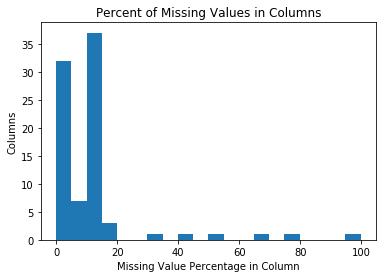

In [17]:
#Set the column name and number of bins


# Create a bar chart with bins
per_column.plot(kind='hist', bins=20)

# Add labels and title
plt.xlabel('Missing Value Percentage in Column')
plt.ylabel('Columns')
plt.title('Percent of Missing Values in Columns')

# Display the chart
plt.show()




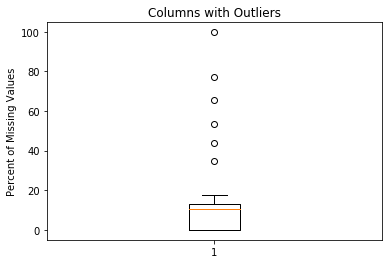

In [18]:
# Create a box plot
plt.boxplot(per_column.values, sym='o', whis=1.5)

# Add labels and title
plt.xlabel('')
plt.ylabel('Percent of Missing Values')
plt.title('Columns with Outliers')

# Display the chart
plt.show()

In [19]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Calculate the number of NaN values per column
nan_counts = azdias_converted_to_Nans.isnull().sum()

# Calculate the total number of rows
total_rows = len(azdias_converted_to_Nans)

# Calculate the percentage of missing data per column before removing outliers
missing_percentage_before = (nan_counts / total_rows) * 100

# Define the threshold for outlier detection
threshold = 1.5

# Calculate the IQR for the number of NaN values
Q1 = nan_counts.quantile(0.25)
Q3 = nan_counts.quantile(0.75)
IQR = Q3 - Q1

# Identify columns with outlier NaN counts
outliers = (nan_counts < (Q1 - threshold * IQR)) | (nan_counts > (Q3 + threshold * IQR))

# Get the list of removed columns
removed_columns = azdias_converted_to_Nans.columns[outliers]

# Get the missing data percentages of removed columns
missing_percentage_removed = missing_percentage_before[outliers]

# Print the list of columns and their corresponding percentages of missing data before removing outliers
print("Columns and their missing data percentages before removing outliers:")
for column, percentage in missing_percentage_before.iteritems():
    print(f"{column}: {percentage:.2f}%")

# Remove columns with outlier NaN counts
azdias_no_outliers = azdias_converted_to_Nans.loc[:, ~outliers]

Columns and their missing data percentages before removing outliers:
AGER_TYP: 76.96%
ALTERSKATEGORIE_GROB: 0.32%
ANREDE_KZ: 0.00%
CJT_GESAMTTYP: 0.54%
FINANZ_MINIMALIST: 0.00%
FINANZ_SPARER: 0.00%
FINANZ_VORSORGER: 0.00%
FINANZ_ANLEGER: 0.00%
FINANZ_UNAUFFAELLIGER: 0.00%
FINANZ_HAUSBAUER: 0.00%
FINANZTYP: 0.00%
GEBURTSJAHR: 44.02%
GFK_URLAUBERTYP: 0.54%
GREEN_AVANTGARDE: 0.00%
HEALTH_TYP: 12.48%
LP_LEBENSPHASE_FEIN: 10.95%
LP_LEBENSPHASE_GROB: 10.61%
LP_FAMILIE_FEIN: 8.73%
LP_FAMILIE_GROB: 8.73%
LP_STATUS_FEIN: 0.54%
LP_STATUS_GROB: 0.54%
NATIONALITAET_KZ: 12.15%
PRAEGENDE_JUGENDJAHRE: 12.14%
RETOURTYP_BK_S: 0.54%
SEMIO_SOZ: 0.00%
SEMIO_FAM: 0.00%
SEMIO_REL: 0.00%
SEMIO_MAT: 0.00%
SEMIO_VERT: 0.00%
SEMIO_LUST: 0.00%
SEMIO_ERL: 0.00%
SEMIO_KULT: 0.00%
SEMIO_RAT: 0.00%
SEMIO_KRIT: 0.00%
SEMIO_DOM: 0.00%
SEMIO_KAEM: 0.00%
SEMIO_PFLICHT: 0.00%
SEMIO_TRADV: 0.00%
SHOPPER_TYP: 12.48%
SOHO_KZ: 8.25%
TITEL_KZ: 99.76%
VERS_TYP: 12.48%
ZABEOTYP: 0.00%
ALTER_HH: 34.81%
ANZ_PERSONEN: 8.25%
ANZ_TI

In [20]:
# Calculate the number of NaN values per column after removing outliers
nan_counts_after = azdias_no_outliers.isnull().sum()

# Calculate the percentage of missing data per column after removing outliers
missing_percentage_after = (nan_counts_after / total_rows) * 100

# Print the list of columns and their corresponding percentages of missing data after removing outliers
print("\nColumns and their missing data percentages after removing outliers:")
for column, percentage in missing_percentage_after.iteritems():
    print(f"{column}: {percentage:.2f}%")


Columns and their missing data percentages after removing outliers:
ALTERSKATEGORIE_GROB: 0.32%
ANREDE_KZ: 0.00%
CJT_GESAMTTYP: 0.54%
FINANZ_MINIMALIST: 0.00%
FINANZ_SPARER: 0.00%
FINANZ_VORSORGER: 0.00%
FINANZ_ANLEGER: 0.00%
FINANZ_UNAUFFAELLIGER: 0.00%
FINANZ_HAUSBAUER: 0.00%
FINANZTYP: 0.00%
GFK_URLAUBERTYP: 0.54%
GREEN_AVANTGARDE: 0.00%
HEALTH_TYP: 12.48%
LP_LEBENSPHASE_FEIN: 10.95%
LP_LEBENSPHASE_GROB: 10.61%
LP_FAMILIE_FEIN: 8.73%
LP_FAMILIE_GROB: 8.73%
LP_STATUS_FEIN: 0.54%
LP_STATUS_GROB: 0.54%
NATIONALITAET_KZ: 12.15%
PRAEGENDE_JUGENDJAHRE: 12.14%
RETOURTYP_BK_S: 0.54%
SEMIO_SOZ: 0.00%
SEMIO_FAM: 0.00%
SEMIO_REL: 0.00%
SEMIO_MAT: 0.00%
SEMIO_VERT: 0.00%
SEMIO_LUST: 0.00%
SEMIO_ERL: 0.00%
SEMIO_KULT: 0.00%
SEMIO_RAT: 0.00%
SEMIO_KRIT: 0.00%
SEMIO_DOM: 0.00%
SEMIO_KAEM: 0.00%
SEMIO_PFLICHT: 0.00%
SEMIO_TRADV: 0.00%
SHOPPER_TYP: 12.48%
SOHO_KZ: 8.25%
VERS_TYP: 12.48%
ZABEOTYP: 0.00%
ANZ_PERSONEN: 8.25%
ANZ_TITEL: 8.25%
HH_EINKOMMEN_SCORE: 2.06%
W_KEIT_KIND_HH: 16.61%
WOHNDAUER_2

In [21]:
# Print the count of columns before and after removing outliers
print(f"\nNumber of columns before removing outliers: {len(azdias_converted_to_Nans.columns)}")
print(f"Number of columns after removing outliers: {len(azdias_no_outliers.columns)}")


Number of columns before removing outliers: 85
Number of columns after removing outliers: 79


In [22]:
# Print the list of removed columns and their corresponding percentages of missing data
print("\nRemoved Columns and their missing data percentages:")
for column, percentage in zip(removed_columns, missing_percentage_removed):
    print(f"{column}: {percentage:.2f}%")


Removed Columns and their missing data percentages:
AGER_TYP: 76.96%
GEBURTSJAHR: 44.02%
TITEL_KZ: 99.76%
ALTER_HH: 34.81%
KK_KUNDENTYP: 65.60%
KBA05_BAUMAX: 53.47%


In [23]:
# Investigate patterns in the amount of missing data in each column.

no_outliers=(azdias_no_outliers.isnull().sum()/len(azdias))*100

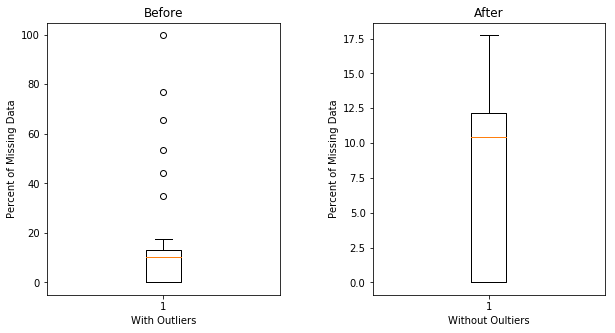

In [24]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first box plot
axs[0].boxplot(per_column.values, sym='o', whis=1.5)
axs[0].set_xlabel('With Outliers')
axs[0].set_ylabel('Percent of Missing Data')
axs[0].set_title('Before')

# Plot the second box plot
axs[1].boxplot(no_outliers.values, sym='o', whis=1.5)
axs[1].set_xlabel('Without Oultiers')
axs[1].set_ylabel('Percent of Missing Data')
axs[1].set_title('After')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Display the chart
plt.show()


#### Discussion 1.1.2: Assess Missing Data in Each Column

First, I examined the dataset by considering the data as percentages in order to identify columns with the highest amount of missing data.

Next, I employed quantiles to detect potential outliers within the dataset. Specifically, I utilized the 1.5 interquartile range (IQR) rule, which allowed me to identify outliers based on their deviation from the third quartile (Q3). By calculating the IQR and multiplying it by 1.5, I established a threshold above which values were considered potential outliers. In this case, only values above the upper threshold were flagged as outliers.

Given that the dataset had zero as the most common value, it was apparent that only values in the third quartile could be potential outliers. Consequently, this approach led to the removal of 6 columns, starting with those that had missing data exceeding 34% of the total.



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

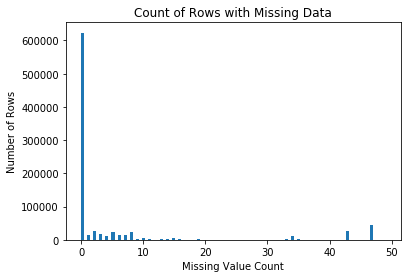

In [25]:
# How much data is missing in each row of the dataset?

# Calculate the number of missing values per row
null_per_row = azdias_no_outliers.isnull().sum(axis=1)

# Create a histogram using 
plt.hist(null_per_row, bins=100)
plt.xlabel('Missing Value Count')
plt.ylabel('Number of Rows')
plt.title('Count of Rows with Missing Data')
plt.show()


In [26]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Set a threshold for the number of missing values to divide the data
threshold = 5

# Subset of rows with missing values below the threshold
Few_Missing_Values = azdias_no_outliers[azdias_no_outliers.isnull().sum(axis=1) < threshold]

# Subset of rows with missing values above or equal to the threshold
Many_Missing_Values= azdias_no_outliers[azdias_no_outliers.isnull().sum(axis=1) >= threshold]






In [27]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.


In [28]:
#First look at the comparison of columns missing the least to columns 
# missing the most.

# Calculate the number of missing values in each column
missing_values = azdias_no_outliers.isnull().sum()

# Calculate the percentage of missing values in each column
missing_percentage = (missing_values / len(azdias_no_outliers)) * 100

# Sort the columns based on the number or percentage of missing values
columns_least_missing = missing_percentage.sort_values().index

# Select the top 5 columns with the least missing data
top_5_columns = columns_least_missing[:5]

# Display the top 5 columns with the least missing data
print("Top 5 columns with the least missing data:")
print(top_5_columns)


Top 5 columns with the least missing data:
Index(['ZABEOTYP', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST'], dtype='object')


In [29]:
def compare_column_distribution(column):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(data=Few_Missing_Values, x=column, color=Few_Missing_Values_color)
    plt.xlabel('Few Missing Values')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.countplot(data=Many_Missing_Values, x=column, color=Many_Missing_Values_color)
    plt.xlabel('Many Missing Values')
    plt.ylabel('Frequency')

    plt.suptitle('Comparison of ' + column + ' Distribution')

    plt.show()



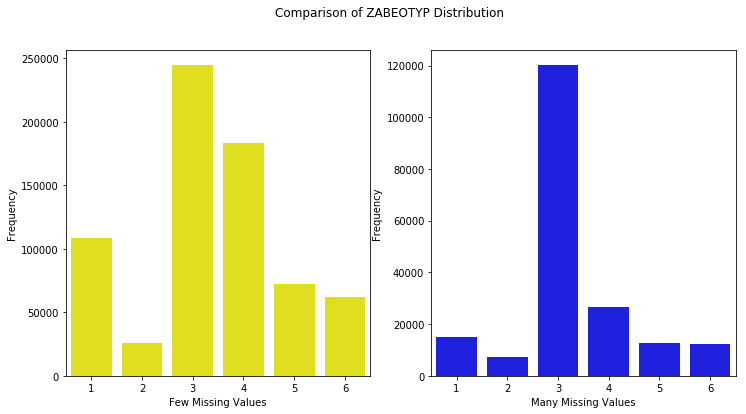

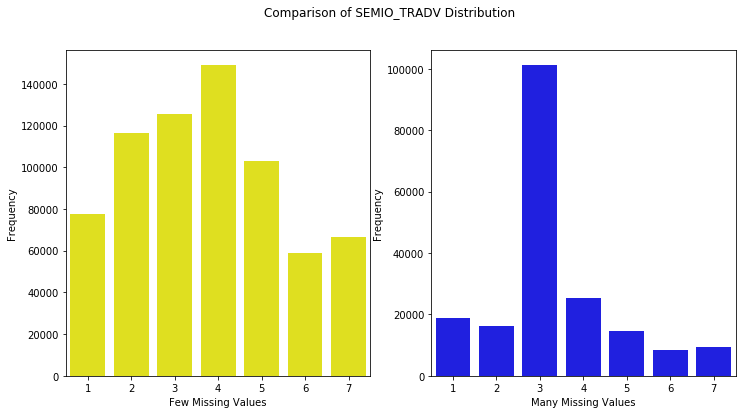

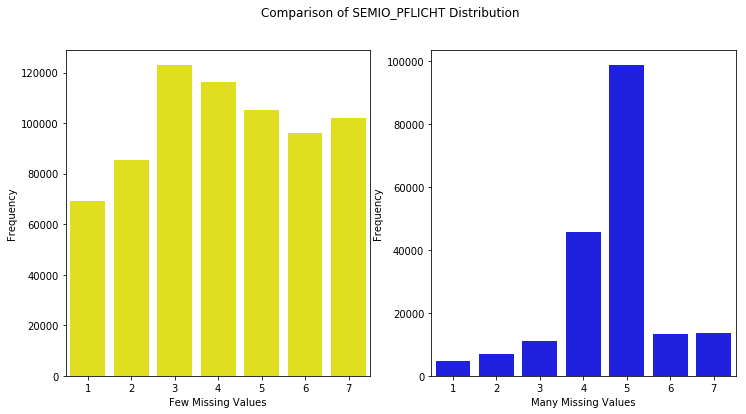

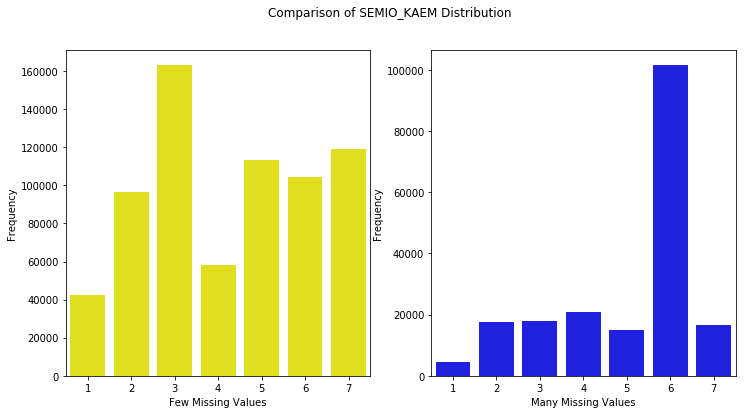

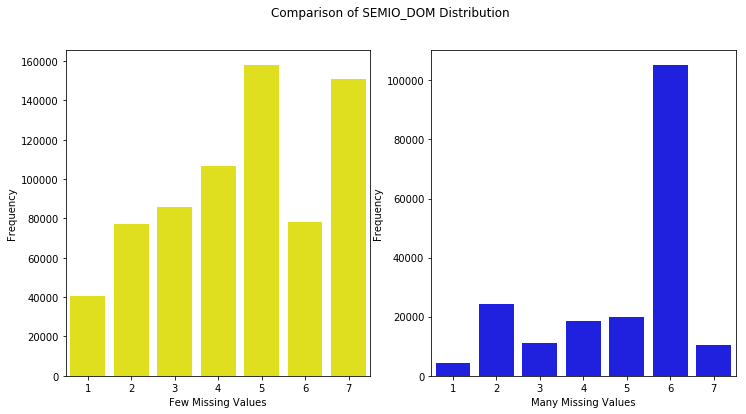

In [30]:
# Specify the columns to compare
columns_to_compare = ['ZABEOTYP', 'SEMIO_TRADV', 'SEMIO_PFLICHT', 'SEMIO_KAEM', 'SEMIO_DOM']

# Define colors for the subsets
Few_Missing_Values_color = 'yellow'
Many_Missing_Values_color = 'blue'

# Call the function for each column
for column in columns_to_compare:
    compare_column_distribution(column)

#### Discussion 1.1.3: Assess Missing Data in Each Row


I decided to focus on comparing columns that have the least amount of missing data. By doing this, I looked at columns where there were only a few missing data points and compared them to columns with a higher number of missing data points.

To determine which columns to compare, I set a threshold of five missing data points. If a column had more than five missing data points, I considered it as having many missing values.

When I examined the distribution of data between these two groups of columns, I noticed something interesting. The value that appeared most frequently in one subset was often different from the value that appeared most frequently in the other subset.

In simpler terms, when comparing the columns with fewer missing values to those with more missing values, I found that the most common value in one group was often different from the most common value in the other group.

This observation suggests that the presence or absence of missing values can have an impact on the distribution and patterns of data in different columns.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [31]:
features = list(azdias_no_outliers)
feat_info_clean = feat_info[feat_info['attribute'].isin(features)]
data_type_count = feat_info_clean['type'].value_counts()

for data_type, count in data_type_count.items():
    print(f"There are {count} {data_type} features.")

There are 49 ordinal features.
There are 18 categorical features.
There are 6 numeric features.
There are 6 mixed features.


In [32]:
print(azdias_no_outliers.columns)

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [33]:
categorical_cols = feat_info_clean[feat_info_clean['type'] == 'categorical']['attribute']
binary_features = []
multi_level_features = []
re_encode_features = []

for feature in categorical_cols:
    unique_values = azdias_no_outliers[feature].unique()

    if len(unique_values) == 2:
        # Check if there are non-numeric values in the binary feature
        if all(isinstance(value, (int, float)) for value in unique_values):
            binary_features.append(feature)
            azdias_no_outliers[feature] = azdias_no_outliers[feature].map({unique_values[0]: 'No', unique_values[1]: 'Yes'})
        else:
            print(f"Dropping column '{feature}' due to non-numeric values.")
            azdias_no_outliers.drop(feature, axis=1, inplace=True)
    elif len(unique_values) > 2:
        multi_level_features.append(feature)
        re_encode_features.append(feature)

# Print the results
print("Binary Features:")
print(binary_features)
print("\nMulti-Level Features:")
print(multi_level_features)
print("\nFeatures needing re-encoding:")
print(re_encode_features)


Dropping column 'ANREDE_KZ' due to non-numeric values.


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Dropping column 'GREEN_AVANTGARDE' due to non-numeric values.
Binary Features:
[]

Multi-Level Features:
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

Features needing re-encoding:
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [34]:
#Rename Cleaned Data

Cleaned_Data = azdias_no_outliers

#### Discussion 1.2.1: Re-Encode Categorical Features

After carefully considering the impact of the variables that needed to be encoded, I made the decision to keep them in the analysis. To implement the encoding process, I utilized the variable with list of columns that required encoding to iterate through and apply the necessary transformations.

By retaining these variables, I aimed to preserve valuable information that could contribute to the predictive power of the model. Although I wasn't certain of the exact impact of these variables on the model's performance, I believed it would be wiser to keep them rather than dropping them altogether. By doing so, I ensured that no potentially significant relationships or patterns were overlooked, allowing the model to leverage all available information and make more accurate predictions.



#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [35]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Step 1: Replace missing value codes with NaNs
missing_codes = ['X', 'XX', '']
Cleaned_Data.replace(missing_codes, np.nan, inplace=True)

# Step 2: Engineer 'DECADE' and 'MOVEMENT' columns and handle missing values
Cleaned_Data['DECADE'] = Cleaned_Data['PRAEGENDE_JUGENDJAHRE']
decade_mapping = {
    1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90
}
Cleaned_Data['DECADE'] = Cleaned_Data['DECADE'].map(decade_mapping)

# Handle missing values in 'DECADE' column
Cleaned_Data['DECADE'] = Cleaned_Data['DECADE'].fillna(-1)  # Replace NaN with a sentinel value (-1) or any other suitable value

Cleaned_Data['MOVEMENT'] = Cleaned_Data['PRAEGENDE_JUGENDJAHRE'].map({
    1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1
})

# Handle missing values in 'MOVEMENT' column
Cleaned_Data['MOVEMENT'] = Cleaned_Data['MOVEMENT'].fillna(-1)  # Replace NaN with a sentinel value (-1) or any other suitable value

# Drop 'PRAEGENDE_JUGENDJAHRE' column
Cleaned_Data.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

# Print the updated DataFrame
print(Cleaned_Data[['DECADE', 'MOVEMENT']])


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/opt/

        DECADE  MOVEMENT
0         -1.0      -1.0
1         90.0       0.0
2         90.0       1.0
3         70.0       0.0
4         70.0       0.0
5         50.0       1.0
6         80.0       0.0
7         70.0       0.0
8         80.0       1.0
9         90.0       1.0
10        50.0       1.0
11        -1.0      -1.0
12        70.0       0.0
13        90.0       1.0
14        -1.0      -1.0
15        60.0       1.0
16        90.0       0.0
17        -1.0      -1.0
18        80.0       0.0
19        70.0       1.0
20        80.0       1.0
21        80.0       0.0
22        90.0       0.0
23        70.0       1.0
24        -1.0      -1.0
25        90.0       0.0
26        70.0       0.0
27        80.0       1.0
28        80.0       0.0
29        60.0       0.0
...        ...       ...
891191    50.0       1.0
891192    90.0       0.0
891193    60.0       1.0
891194    80.0       1.0
891195    70.0       0.0
891196    90.0       0.0
891197    80.0       1.0
891198    90.0       1.0


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [36]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Convert "CAMEO_INTL_2015" column to numeric
Cleaned_Data['CAMEO_INTL_2015'] = pd.to_numeric(Cleaned_Data['CAMEO_INTL_2015'], errors='coerce')

# Create new ordinal variables for wealth and life stage
Cleaned_Data['WEALTH'] = Cleaned_Data['CAMEO_INTL_2015'] // 10
Cleaned_Data['LIFE_STAGE'] = Cleaned_Data['CAMEO_INTL_2015'] % 10

Cleaned_Data.drop('CAMEO_INTL_2015', axis=1, inplace=True)

# Print the updated DataFrame
print(Cleaned_Data[['WEALTH', 'LIFE_STAGE']])





/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

        WEALTH  LIFE_STAGE
0          NaN         NaN
1          5.0         1.0
2          2.0         4.0
3          1.0         2.0
4          4.0         3.0
5          5.0         4.0
6          2.0         2.0
7          1.0         4.0
8          1.0         3.0
9          1.0         5.0
10         5.0         1.0
11         NaN         NaN
12         4.0         3.0
13         3.0         3.0
14         NaN         NaN
15         4.0         1.0
16         4.0         1.0
17         NaN         NaN
18         2.0         4.0
19         3.0         4.0
20         2.0         4.0
21         5.0         5.0
22         5.0         1.0
23         4.0         3.0
24         NaN         NaN
25         3.0         3.0
26         NaN         NaN
27         5.0         1.0
28         1.0         3.0
29         1.0         2.0
...        ...         ...
891191     4.0         4.0
891192     3.0         2.0
891193     4.0         3.0
891194     2.0         4.0
891195     5.0         5.0
8

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### Discussion 1.2.2: Engineer Mixed-Type Features

I decided to only focuse on the two features suggested because I understand the implication of the data shared. These features had mixed information, meaning they had different kinds of data mixed together. To make it easier to understand and use, I decided to create new features from them.

The first feature is called 'PRAEGENDE_JUGENDJAHRE'. From this feature, I made two new features called 'DECADE' and 'MOVEMENT'. 'DECADE' tells us which decade a person belongs to based on their youth. To do this, I looked at each unique value in 'PRAEGENDE_JUGENDJAHRE' and assigned it to the corresponding decade. 'MOVEMENT' tells us if a person follows mainstream or avant-garde styles. I used the unique values in 'PRAEGENDE_JUGENDJAHRE' to create this new feature.

The second feature is called 'CAMEO_INTL_2015'. I wanted to understand two aspects of this feature: wealth and life stage. To separate this information, I looked at the two-digit codes in 'CAMEO_INTL_2015'. I focused on the first digit, which represents wealth, and created a new variable called 'WEALTH'. By doing this, I could see the wealth information more clearly. Then, I looked at the second digit, which represents life stage, and created a new variable called 'LIFE_STAGE'. This helped me understand the different life stages of the people in the data.

By making these changes, I made the data easier to work with and understand. Now, I have new features that provide insights about decades, movement styles, wealth, and life stages, which will help me in my analysis.



#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [37]:
mixed_data_columns = []

# Iterate over the columns
for column in Cleaned_Data.columns:
    column_data_types = Cleaned_Data[column].apply(type).unique()
    
    # Check if more than one data type is present in the column
    if len(column_data_types) > 1:
        mixed_data_columns.append(column)

# Print the columns with mixed data types
print("Columns with mixed data types:")
print(mixed_data_columns)

Columns with mixed data types:
['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [38]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Check the data types of columns in the cleaned_data_final DataFrame
column_data_types = Cleaned_Data.dtypes

# Print the data types
print(column_data_types)



ALTERSKATEGORIE_GROB     float64
CJT_GESAMTTYP            float64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
FINANZTYP                  int64
GFK_URLAUBERTYP          float64
HEALTH_TYP               float64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
LP_FAMILIE_FEIN          float64
LP_FAMILIE_GROB          float64
LP_STATUS_FEIN           float64
LP_STATUS_GROB           float64
NATIONALITAET_KZ         float64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
SEMIO_ERL                  int64
SEMIO_KULT                 int64
SEMIO_RAT                  int64
SEMIO_KRIT                 int64
SEMIO_DOM                  int64
          

In [39]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



In [40]:
def impute_missing_values(data_c, strategy_numeric='mean', strategy_string='most_frequent'):
    numeric_cols = data_c.select_dtypes(include=[np.number]).columns
    string_cols = data_c.select_dtypes(include=[object]).columns

    # Impute missing values for numeric columns
    for col in numeric_cols:
        if strategy_numeric == 'mean':
            data_c[col].fillna(data_c[col].mean(), inplace=True)
        elif strategy_numeric == 'median':
            data_c[col].fillna(data_c[col].median(), inplace=True)
        elif strategy_numeric == 'mode':
            data_c[col].fillna(data_c[col].mode().iloc[0], inplace=True)

    # Impute missing values for string columns
    for col in string_cols:
        data_c[col].fillna(data_c[col].mode().iloc[0], inplace=True)

    return data_c

# Call the impute_missing_values function
imputed_df = impute_missing_values(Cleaned_Data)

# Check for NaN values in the DataFrame
nan_count = imputed_df.isnull().sum().sum()

if nan_count == 0:
    print("No NaN values found in the DataFrame.")
else:
    print(f"There are {nan_count} NaN values in the DataFrame.")

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


No NaN values found in the DataFrame.


In [41]:
def drop_non_numeric(data):
    non_numeric_columns = []

    for column in data.columns:
        if not data[column].apply(lambda x: isinstance(x, (int, float))).all():
            non_numeric_columns.append(column)

    print("Columns with non-numeric values:")
    print(non_numeric_columns)

    columns_to_drop = ['OST_WEST_KZ','CAMEO_DEU_2015', 'CAMEO_DEUG_2015']
    data.drop(columns_to_drop, axis=1, inplace=True)

    return data

In [42]:
cleaned_data_numeric = drop_non_numeric(imputed_df)

Columns with non-numeric values:
['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [66]:
def clean_data(df):

    # Convert missing value codes into NaNs
    df_missing_data = update_missing_data(feat_info, df)
    
    # Remove selected columns with outlier NaN counts
    nan_counts = df_missing_data .isnull().sum()
    Q1 = nan_counts.quantile(0.25)
    Q3 = nan_counts.quantile(0.75)
    IQR = Q3 - Q1
    threshold = 1.5
    outliers = (nan_counts < (Q1 - threshold * IQR)) | (nan_counts > (Q3 + threshold * IQR))
    removed_columns = df_missing_data.columns[outliers]
    df_missing_data  = df_missing_data .loc[:, ~outliers]
    
    # Categorical feature processing
    categorical_cols = feat_info_clean[feat_info_clean['type'] == 'categorical']['attribute']
    binary_features = []
    multi_level_features = []
    re_encode_features = []

        
    for feature in categorical_cols:
        unique_values = df_missing_data [feature].unique()

        if len(unique_values) == 2:
            # Check if there are non-numeric values in the binary feature
            if all(isinstance(value, (int, float)) for value in unique_values):
                binary_features.append(feature)
                df_missing_data[feature] = df_missing_data[feature].map({unique_values[0]: 'No', unique_values[1]: 'Yes'})
            else:
                print(f"Dropping column '{feature}' due to non-numeric values.")
                df_missing_data.drop(feature, axis=1, inplace=True)
        elif len(unique_values) > 2:
            multi_level_features.append(feature)
            re_encode_features.append(feature)

    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    
    # Step 1: Replace missing value codes with NaNs
    missing_codes = ['X', 'XX', '']
    df_missing_data.replace(missing_codes, np.nan, inplace=True)

    # Step 2: Engineer 'DECADE' and 'MOVEMENT' columns and handle missing values
    df_missing_data['DECADE'] = df_missing_data['PRAEGENDE_JUGENDJAHRE']
    decade_mapping = {
        1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90
    }
    df_missing_data['DECADE'] = df_missing_data['DECADE'].map(decade_mapping)

    # Handle missing values in 'DECADE' column
    df_missing_data['DECADE'] = df_missing_data['DECADE'].fillna(-1)  # Replace NaN with a sentinel value (-1) or any other suitable value

    df_missing_data['MOVEMENT'] = df_missing_data['PRAEGENDE_JUGENDJAHRE'].map({
        1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1
    })

    # Handle missing values in 'MOVEMENT' column
    df_missing_data['MOVEMENT'] = df_missing_data['MOVEMENT'].fillna(-1)  # Replace NaN with a sentinel value (-1) or any other suitable value

    # Drop 'PRAEGENDE_JUGENDJAHRE' column
    df_missing_data.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

    # Print the updated DataFrame
    print(df_missing_data[['DECADE', 'MOVEMENT']])
    
    # Drop original columns used for engineering
   

    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.

    # Convert "CAMEO_INTL_2015" column to numeric
    df_missing_data['CAMEO_INTL_2015'] = pd.to_numeric(df_missing_data['CAMEO_INTL_2015'], errors='coerce')

    # Create new ordinal variables for wealth and life stage
    df_missing_data['WEALTH'] = df_missing_data['CAMEO_INTL_2015'] // 10
    df_missing_data['LIFE_STAGE'] = df_missing_data['CAMEO_INTL_2015'] % 10

    df_missing_data.drop('CAMEO_INTL_2015', axis=1, inplace=True)

    # Print the updated DataFrame
    print(df_missing_data[['WEALTH','LIFE_STAGE']])
    
    df_impute = impute_missing_values(df_missing_data)
    
    df_non_numeric = drop_non_numeric(df_impute)
    
    return df_non_numeric
    


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [44]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Check for NaN values in the DataFrame
nan_count = cleaned_data_numeric.isnull().sum().sum()

if nan_count == 0:
    print("No NaN values found in the DataFrame.")
else:
    print(f"There are {nan_count} NaN values in the DataFrame.")



No NaN values found in the DataFrame.


In [45]:
# Get the list of features with missing values
features_with_missing = Cleaned_Data.columns[Cleaned_Data.isnull().sum() > 0].tolist()

# Print the list of features with missing values
print("Features with missing values:")
for feature in features_with_missing:
    print(feature)
    

Features with missing values:


In [46]:

target_value = '6B'

columns_with_value_w = []

for column in cleaned_data_numeric.columns:
    if target_value in cleaned_data_numeric[column].values:
        columns_with_value_w.append(column)

if columns_with_value_w:
    print(f"The value '{target_value}' is found in the following columns: {', '.join(columns_with_value_w)}")
else:
    print(f"The value '{target_value}' was not found in any column.")


The value '6B' was not found in any column.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


In [47]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

# Create an instance of StandardScaler
scaler = StandardScaler()

# Apply feature scaling to all columns in the Cleaned_Data DataFrame
scaled_data = scaler.fit_transform(cleaned_data_numeric.values)

# Create a new DataFrame with the scaled data and the same column names
scaled_df = pd.DataFrame(scaled_data, columns=cleaned_data_numeric.columns)

# Print the updated DataFrame
print(scaled_df)



        ALTERSKATEGORIE_GROB  CJT_GESAMTTYP  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                  -0.750972      -1.026509          -0.056416       0.804890   
1                  -1.742724       0.859488          -1.570358       1.487601   
2                   0.240781      -0.397844          -1.570358       0.804890   
3                   1.232533      -1.026509           0.700556      -0.560532   
4                   0.240781       0.859488           0.700556       0.122179   
5                  -1.742724      -1.026509          -0.056416      -1.243244   
6                  -0.750972       0.859488          -1.570358       1.487601   
7                  -1.742724      -0.397844          -0.056416       0.122179   
8                   0.240781      -0.397844           0.700556       0.804890   
9                   0.240781       0.230822          -0.813387       0.804890   
10                  0.240781      -1.655175          -0.813387      -0.560532   
11                 -0.750972

### Discussion 2.1: Apply Feature Scaling

To prepare the data for feature scaling, I first handled missing values by imputing them with the mean value strategy. This involved replacing any missing values in the dataset with the mean value of the respective column.

Additionally, I dropped any columns that contained non-numeric values. This step ensured that only columns with numeric data remained in the dataset, allowing for the application of feature scaling techniques.

By addressing missing values and removing non-numeric columns, I created a clean dataset suitable for further analysis and scaling of the numeric features.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [48]:
# Apply PCA to the data.

pca = PCA()

pca.fit(scaled_df)

variance_explained = pca.explained_variance_ratio_

cumulative_variance_explained = np.cumsum(variance_explained)


transformed_data = pca.fit_transform(scaled_df)



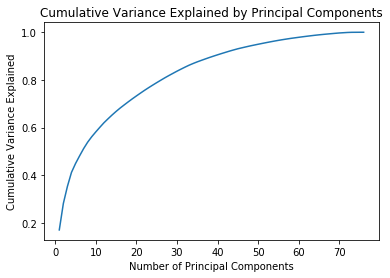

In [49]:
# Investigate the variance accounted for by each principal component.
plt.plot(range(1, len(cumulative_variance_explained) + 1), cumulative_variance_explained)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components')
plt.show()




In [50]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca40 = PCA(n_components=40)

pca_azdias = pca40.fit_transform(scaled_df)


### Discussion 2.2: Perform Dimensionality Reduction

After conducting the analysis and observing the variance explained by each principal component, I made a decision to retain forty components. I chose this number because I noticed that beyond this point, the curve of the explained variance started to flatten, indicating diminishing returns in terms of capturing additional information. Adding more features beyond this threshold is unlikely to significantly improve the results. By selecting sixty components, I am able to retain a substantial amount of the variability present in the original data while achieving a good balance between dimensionality reduction and information preservation. This choice allows for a more concise representation of the data, enabling efficient analysis and interpretation in subsequent steps of the project.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [51]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# Get the index of the first principal component
component_index = 0

# Get the feature names from the original DataFrame
feature_names = scaled_df.columns

 # Print the name of the feature associated with the first principal component
print("First Principal Component Feature:")
print(feature_names[component_index])


First Principal Component Feature:
ALTERSKATEGORIE_GROB


In [52]:
def print_feature_weights(pca, component_index, feature_names):
    # Get the feature weights for the specified principal component
    feature_weights = {feature: weight for feature, weight in zip(feature_names, pca.components_[component_index])}

    # Sort the feature weights by weight in ascending order
    sorted_weights = sorted(feature_weights.items(), key=lambda x: x[1])

    # Create two separate lists for feature names and weights
    sorted_feature_names = [feature for feature, _ in sorted_weights]
    sorted_weights = [weight for _, weight in sorted_weights]

    # Determine the maximum length of feature names for alignment
    max_name_length = max(len(feature) for feature in sorted_feature_names)

    # Print the linked values, sorted by weight with added spacing
    for feature, weight in zip(sorted_feature_names, sorted_weights):
        # Format the feature name with added spacing
        formatted_name = f"{feature: <{max_name_length}}"

        print(f"Feature: {formatted_name}    Weight: {weight}")


# Feature 1
component_index = 0  # Index of the principal component to investigate
feature_names = scaled_df.columns  # List of feature names from the original DataFrame

# Sort feature_names in a specific order (e.g., alphabetical)
sorted_feature_names = sorted(feature_names)

# Call the function to print the feature weights for the first principal component
print_feature_weights(pca, component_index, sorted_feature_names)



Feature: SEMIO_KRIT               Weight: -0.2247694330025335
Feature: FINANZ_UNAUFFAELLIGER    Weight: -0.2157338631739317
Feature: FINANZ_VORSORGER         Weight: -0.2116824442341177
Feature: PLZ8_BAUMAX              Weight: -0.20871216084927377
Feature: SEMIO_PFLICHT            Weight: -0.2072007504183349
Feature: RELAT_AB                 Weight: -0.2014882167987131
Feature: ANZ_HH_TITEL             Weight: -0.19215696761705348
Feature: PLZ8_ANTG2               Weight: -0.15601841328100124
Feature: FINANZ_ANLEGER           Weight: -0.15286913506190253
Feature: SEMIO_ERL                Weight: -0.15197733862274068
Feature: SHOPPER_TYP              Weight: -0.15189037546135298
Feature: FINANZ_HAUSBAUER         Weight: -0.13989490109616218
Feature: RETOURTYP_BK_S           Weight: -0.11785977996914442
Feature: SEMIO_FAM                Weight: -0.11000280493716623
Feature: ZABEOTYP                 Weight: -0.10926863427529464
Feature: FINANZ_SPARER            Weight: -0.108527163928490

In [53]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Get the index of the second principal component
component_index = 1

# Get the feature names from the original DataFrame
feature_names = scaled_df.columns

# Print the name of the feature associated with the first principal component
print("Second Principal Component Feature:")
print(feature_names[component_index])

Second Principal Component Feature:
CJT_GESAMTTYP


In [54]:
# Feature 2
component_index = 1  # Index of the principal component to investigate
feature_names = Cleaned_Data.columns  # List of feature names from the original DataFrame

# Call the function to print the feature weights for the first principal component
print_feature_weights(pca, component_index, feature_names)

Feature: FINANZ_SPARER            Weight: -0.2695488731204282
Feature: SEMIO_REL                Weight: -0.26059283192933835
Feature: SEMIO_PFLICHT            Weight: -0.25552207056373794
Feature: FINANZ_UNAUFFAELLIGER    Weight: -0.2448350274090011
Feature: SEMIO_TRADV              Weight: -0.23892780164057073
Feature: FINANZ_ANLEGER           Weight: -0.23641926373765423
Feature: SEMIO_RAT                Weight: -0.20863142170820212
Feature: SEMIO_KULT               Weight: -0.1820816321816851
Feature: SEMIO_FAM                Weight: -0.17257801706995876
Feature: SEMIO_MAT                Weight: -0.17254109838503578
Feature: ONLINE_AFFINITAET        Weight: -0.15892822219769923
Feature: CJT_GESAMTTYP            Weight: -0.14221853314639155
Feature: DECADE                   Weight: -0.08946925334754674
Feature: NATIONALITAET_KZ         Weight: -0.08291989155632133
Feature: LP_FAMILIE_GROB          Weight: -0.07893127446037458
Feature: LP_FAMILIE_FEIN          Weight: -0.0775634390760

In [55]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Get the index of the third principal component
component_index = 2

# Get the feature names from the original DataFrame
feature_names = scaled_df.columns

# Print the name of the feature associated with the first principal component
print("Third Principal Component Feature:")
print(feature_names[component_index])

Third Principal Component Feature:
FINANZ_MINIMALIST


In [56]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# Feature 3
component_index = 2  # Index of the principal component to investigate
feature_names = scaled_df.columns  # List of feature names from the original DataFrame

# Call the function to print the feature weights for the first principal component
print_feature_weights(pca, component_index, feature_names)


Feature: SEMIO_KAEM               Weight: -0.37477143636285964
Feature: SEMIO_DOM                Weight: -0.34732417291850426
Feature: SEMIO_KRIT               Weight: -0.33388501060117304
Feature: SEMIO_ERL                Weight: -0.19104726369387373
Feature: FINANZ_ANLEGER           Weight: -0.17780621469573055
Feature: SEMIO_RAT                Weight: -0.1612155831888099
Feature: SHOPPER_TYP              Weight: -0.15817506687010338
Feature: FINANZ_UNAUFFAELLIGER    Weight: -0.10842552655124882
Feature: FINANZ_SPARER            Weight: -0.07812458204258227
Feature: FINANZ_HAUSBAUER         Weight: -0.056825675874444787
Feature: CJT_GESAMTTYP            Weight: -0.05490255511487185
Feature: ZABEOTYP                 Weight: -0.03721402464182869
Feature: PLZ8_ANTG1               Weight: -0.03706186364656378
Feature: PLZ8_GBZ                 Weight: -0.03538846085625285
Feature: SEMIO_PFLICHT            Weight: -0.03280820046922355
Feature: INNENSTADT               Weight: -0.0289455551

### Discussion 2.3: Interpret Principal Components


As I analyzde the principal features, the first principal component, which is associated with estimated age (ALTERSKATEGORIE_GROB), shows a moderate positive correlation with the rational thought process (FINANZ_MINIMALIST) at a weight of 0.19. This suggests that individuals with higher estimated age tend to exhibit more rational thinking in their financial behavior.

On the other hand, the first principal component has a stronger negative correlation with being a money saver (FINANZ_SPARER) at a weight of -0.21. This implies that as the estimated age increases, there is a tendency for individuals to be less inclined to save money.

These associations indicate that estimated age plays a role in shaping both the rational financial behavior and the inclination towards saving money. However, it's important to note that the weights alone do not provide a complete understanding of the relationships between these features. Further analysis and domain knowledge would be necessary to gain deeper insights into the underlying factors and potential causality between estimated age, rational thought process, and saving behavior.

Overall, these findings highlight the importance of estimated age in explaining variations in financial attitudes and behaviors, providing valuable insights for understanding consumer preferences and decision-making processes.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [57]:
def compute_average_distances(data, cluster_range):
    average_distances = []
    
    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_assignments = kmeans.fit_predict(data)
        distances = kmeans.transform(data)
        average_distance = np.mean(np.min(distances, axis=1))
        average_distances.append(average_distance)
        
    return average_distances

In [58]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
cluster_range = range(2, 11)
    
    # compute the average within-cluster distances.
average_distances = compute_average_distances(scaled_df, cluster_range)
    

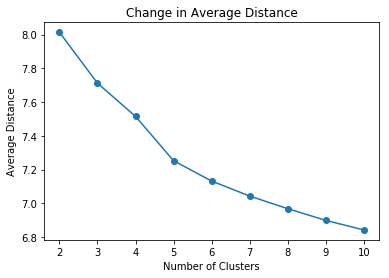

In [59]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



def plot_average_distances(cluster_range, average_distances):
    plt.plot(cluster_range, average_distances, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Average Distance')
    plt.title('Change in Average Distance')
    plt.show()

plot_average_distances(cluster_range, average_distances)



In [60]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

k = 6 

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(scaled_df)


general_cluster_predictions = kmeans.predict(scaled_df)


### Discussion 3.1: Apply Clustering to General Population

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.


### Step 3.2: Apply All Steps to the Customer Data


- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [67]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")

In [68]:
cleaned_customers_demo = clean_data(customers)

Dropping column 'ANREDE_KZ' due to non-numeric values.
Dropping column 'GREEN_AVANTGARDE' due to non-numeric values.


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:49: Setti

        DECADE  MOVEMENT
0         50.0       0.0
1         -1.0      -1.0
2         50.0       0.0
3         40.0       1.0
4         70.0       0.0
5         50.0       0.0
6         50.0       0.0
7         50.0       0.0
8         40.0       1.0
9         70.0       1.0
10        70.0       0.0
11        50.0       0.0
12        70.0       0.0
13        70.0       0.0
14        40.0       1.0
15        60.0       0.0
16        50.0       0.0
17        90.0       1.0
18        90.0       0.0
19        70.0       0.0
20        80.0       1.0
21        60.0       1.0
22        40.0       1.0
23        70.0       0.0
24        50.0       1.0
25        80.0       1.0
26        50.0       1.0
27        70.0       1.0
28        40.0       1.0
29        60.0       1.0
...        ...       ...
191622    40.0       1.0
191623    60.0       0.0
191624    70.0       1.0
191625    50.0       0.0
191626    70.0       0.0
191627    50.0       1.0
191628    60.0       0.0
191629    40.0       1.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


        WEALTH  LIFE_STAGE
0          1.0         3.0
1          NaN         NaN
2          3.0         4.0
3          2.0         4.0
4          4.0         1.0
5          3.0         4.0
6          2.0         3.0
7          1.0         5.0
8          5.0         5.0
9          1.0         5.0
10         NaN         NaN
11         1.0         4.0
12         2.0         2.0
13         4.0         3.0
14         5.0         1.0
15         1.0         5.0
16         1.0         5.0
17         1.0         4.0
18         4.0         1.0
19         2.0         4.0
20         3.0         3.0
21         4.0         3.0
22         2.0         4.0
23         5.0         1.0
24         3.0         3.0
25         2.0         2.0
26         2.0         5.0
27         4.0         4.0
28         5.0         4.0
29         5.0         1.0
...        ...         ...
191622     4.0         3.0
191623     1.0         4.0
191624     5.0         4.0
191625     2.0         5.0
191626     2.0         4.0
1

In [ ]:
def add_missing_dummy_columns(d, columns):
    missing_cols = set(columns) - set(d.columns)
    print(missing_cols)
    for c in missing_cols:
        d[c] = 0
           
def fix_columns(d, columns):  
    add_missing_dummy_columns(d, columns)
    # make sure we have all the columns we need
    assert(set(columns) - set(d.columns) == set())
    extra_cols = set(d.columns) - set(columns)
    if extra_cols:
        print("extra columns:", extra_cols)
    d = d[columns]
    return d
cleaned_customers_demo_fixed = fix_columns(cleaned_customers_demo, cleaned_data_numeric.columns.tolist())

In [69]:
#Apply Scaler

# Create an instance of StandardScaler
#scaler = StandardScaler()

# Apply feature scaling to all columns in the Cleaned_Data DataFrame
scaled_customer = scaler.transform(cleaned_customers_demo_fixed.values)

# Create a new DataFrame with the scaled data and the same column names
scaled_customer_data = pd.DataFrame(scaled_customer, columns=cleaned_customers_demo_fixed.columns)

# Print the updated DataFrame
print(scaled_customer_data)

ValueError: operands could not be broadcast together with shapes (191652,81) (76,) (191652,81) 

In [72]:
def add_missing_dummy_columns(d, columns):
    missing_cols = set(columns) - set(d.columns)
    print(missing_cols)
    for c in missing_cols:
        d[c] = 0
           
def fix_columns(d, columns):  
    add_missing_dummy_columns(d, columns)
    # make sure we have all the columns we need
    assert(set(columns) - set(d.columns) == set())
    extra_cols = set(d.columns) - set(columns)
    if extra_cols:
        print("extra columns:", extra_cols)
    d = d[columns]
    return d


cleaned_customers_demo = fix_columns(cleaned_customers_demo, cleaned_data_numeric.columns.tolist())

set()
extra columns: {'GEBURTSJAHR', 'KK_KUNDENTYP', 'AGER_TYP', 'ALTER_HH', 'KBA05_BAUMAX'}


In [ ]:
#PCA Transform

pca = PCA()

pca.transform(scaled_customer_data)

variance_explained = pca.explained_variance_ratio_

cumulative_variance_explained = np.cumsum(variance_explained)


transformed_data = pca.transform(scaled_customer_data)


In [ ]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca40 = PCA(n_components=40)

pca_customer = pca40.transform(scaled_customer_data)

In [ ]:
#Kmeans

k = 6 

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(pca_customer)

customer_cluster_predictions = kmeans.predict(pca_customer)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

max_count = max(np.max(np.bincount(customer_cluster_predictions)),
                np.max(np.bincount(general_cluster_predictions)))

customers_palette = 'Blues'  
azdias_palette = 'Greens'    

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.subplots_adjust(wspace=0.5)

sns.countplot(customer_cluster_predictions, ax=axs[0], palette=customers_palette)
axs[0].set_title('Customer Clusters')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Count')
axs[0].set_ylim(0, max_count) 

sns.countplot(general_cluster_predictions, ax=axs[1], palette=azdias_palette)
axs[1].set_title('General Clusters')
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('Count')
axs[1].set_ylim(0, max_count)

plt.show()

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#Analyze cluster sizes (proportions) for customer data
cluster_sizes_customer = pd.Series(customer_cluster_predictions).value_counts()
total_customers = len(customer_cluster_predictions)


In [ ]:
#Compare cluster size to general population
cluster_sizes_general_population = pd.Series(general_cluster_predictions).value_counts()
total_general_population = len(general_cluster_predictions)


In [ ]:
#Calculate proportions relative to the general population
cluster_proportions_relative = cluster_sizes_customer / total_customers / (cluster_sizes_general_population / total_general_population)


In [ ]:
#Review over represented group

threshold_over_represented = 1.5

overrepresented_clusters = cluster_proportions_relative[cluster_proportions_relative > threshold_over_represented]

for cluster_label in overrepresented_clusters.index:

    cluster_data_over = cleaned_customers_demo[customer_cluster_predictions == cluster_label]

    print(f"Cluster {cluster_label}: Number of customers = {len(cluster_data_over)}")

    

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#Review  under represented group

threshold_under_represented = .75

underrepresented_clusters = cluster_proportions_relative[cluster_proportions_relative < threshold_under_represented]

for cluster_label in underrepresented_clusters.index:

    cluster_data_over = cleaned_customers_demo[customer_cluster_predictions == cluster_label]

    print(f"Cluster {cluster_label}: Number of customers = {len(cluster_data_over)}")


In [ ]:
cleaned_customers_demo['cluster_label'] = customer_cluster_predictions

cluster_modes = cleaned_customers_demo.groupby('cluster_label').agg(lambda x: x.mode().iloc[0])

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("Cluster Mode:")
print(cluster_modes)

### Discussion 3.3: Compare Customer Data to Demographics Data
Cluster 0 (Overrepresented Group):

Demographic data in this group appears to be incomplete, with a significant amount of missing data indicated by the predominant value of 0.
This group shows a strong inclination towards nature, suggesting that they may be nature lovers.
Financially, they exhibit a tendency towards saving, and their average level of home ownership indicates moderate property investment.
Socially, they are highly engaged and seem to be actively involved in various community-minded activities, though they do not show a particular inclination towards family matters.
Cluster 5 (Underrepresented Group):

This group is the least represented within the customer dataset, suggesting that it is a relatively small segment.
Members of this group are typically over the age of 60 and exhibit a more cultured and refined disposition.
Financially, they appear to be well-prepared and demonstrate a higher level of financial stability compared to other clusters.
Home ownership is more common within this group, indicating a preference for settling in their own homes rather than renting.
In summary, the overrepresented group (Cluster 0) showcases nature-loving individuals with an inclination towards saving and community engagement. On the other hand, the underrepresented group (Cluster 5) consists of more mature, cultured individuals who are financially stable and tend to own their homes.
    


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.